In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from a4_utils import *

def simple_convolution(signal, kernel):
    N = int(len(kernel) / 2) # kernel of size 2N + 1
    returnSignal = np.zeros(len(signal))
    for i in range(0, len(signal)): # loop through signal
        for j in range(0, 2*N+1): # loop through kenel
            index = i-(j-N)
            if index < 0: # extending edge
                index = 0
            elif index > len(signal)-1:
                index = len(signal)-1
            returnSignal[i] += kernel[j]*signal[index] # weigted sum

    return returnSignal

    
def gauss(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    for x in range(-N, N):
        kernel[x+N] = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-x**2 / (2 * (sigma**2)))

    return kernel / np.sum(kernel)

def gaussdx(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    sumOfAbs = 0
    for x in range(-N, N):
        v = -1 / (np.sqrt(2 * np.pi) * sigma**3) * x * np.exp(-x**2 / (2 * (sigma**2)))
        kernel[x+N] = v
        sumOfAbs += np.abs(v)

    return kernel / sumOfAbs

def partialDerivative(img, sigma):
    gaussKenrnel = gauss(sigma)
    dxGaussKernel = gaussdx(sigma)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, dxGaussKernel)
    return img

def getDerivatives(img, sigma):
    Ix = partialDerivative(np.copy(img), sigma)
    Iy = partialDerivative(np.copy(img.T), sigma).T
    Ixx = partialDerivative(np.copy(Ix), sigma)
    Iyy = partialDerivative(np.copy(Iy.T), sigma).T
    Ixy = partialDerivative(np.copy(Ix.T), sigma).T
    return Ix,Iy,Ixx,Iyy,Ixy

def gradient_magnitude(img):
    Ix, Iy, Ixx, Iyy, Ixy = getDerivatives(img, 1)
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    angle = np.arctan2(Ix,Iy)
    return magnitude, angle

# Exercise 1

In [171]:
temp = cv2.imread('data/graf/graf_a.jpg') # 0-255
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
temp = temp.astype(np.float64) / 255

Ix3, Iy3, Ixx3, Iyy3, Ixy3 = getDerivatives(temp, 3)
Ix6, Iy6, Ixx6, Iyy6, Ixy6 = getDerivatives(temp, 6)
Ix9, Iy9, Ixx9, Iyy9, Ixy9 = getDerivatives(temp, 9)



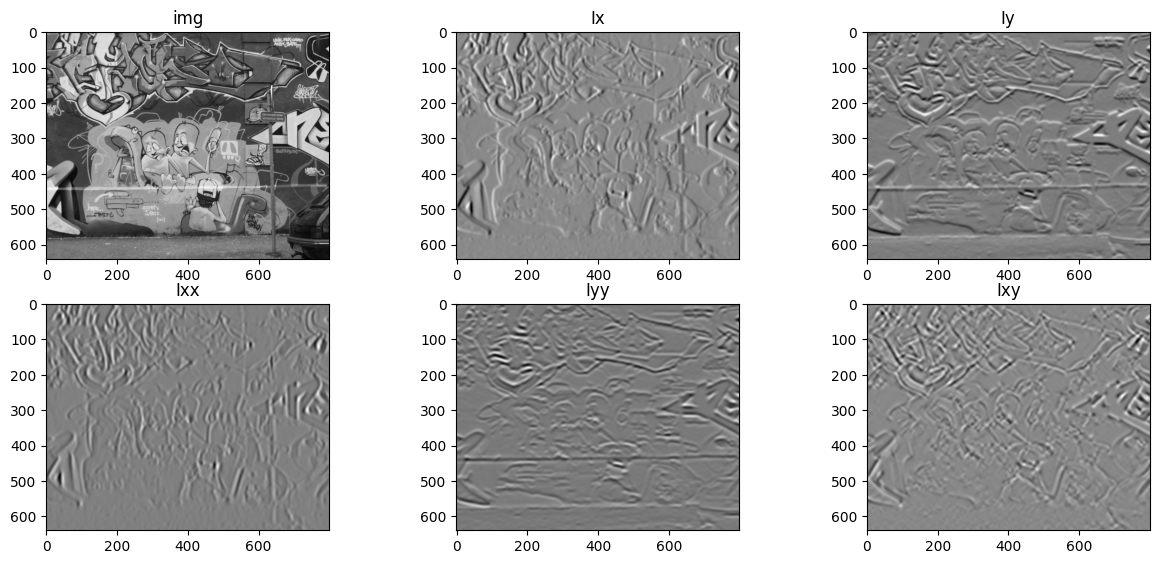

In [172]:
f = plt.figure(figsize=(15, 10))
f.add_subplot(3, 3, 1)
plt.imshow(temp, cmap="gray")
plt.title("img")
f.add_subplot(3, 3, 2)
plt.imshow(Ix3, cmap="gray")
plt.title("Ix")
f.add_subplot(3, 3, 3)
plt.imshow(Iy3, cmap="gray")
plt.title("Iy")
f.add_subplot(3, 3, 4)
plt.imshow(Ixx3, cmap="gray")
plt.title("Ixx")
f.add_subplot(3, 3, 5)
plt.imshow(Iyy3, cmap="gray")
plt.title("Iyy")
f.add_subplot(3, 3, 6)
plt.imshow(Ixy3, cmap="gray")
plt.title("Ixy")
plt.show()

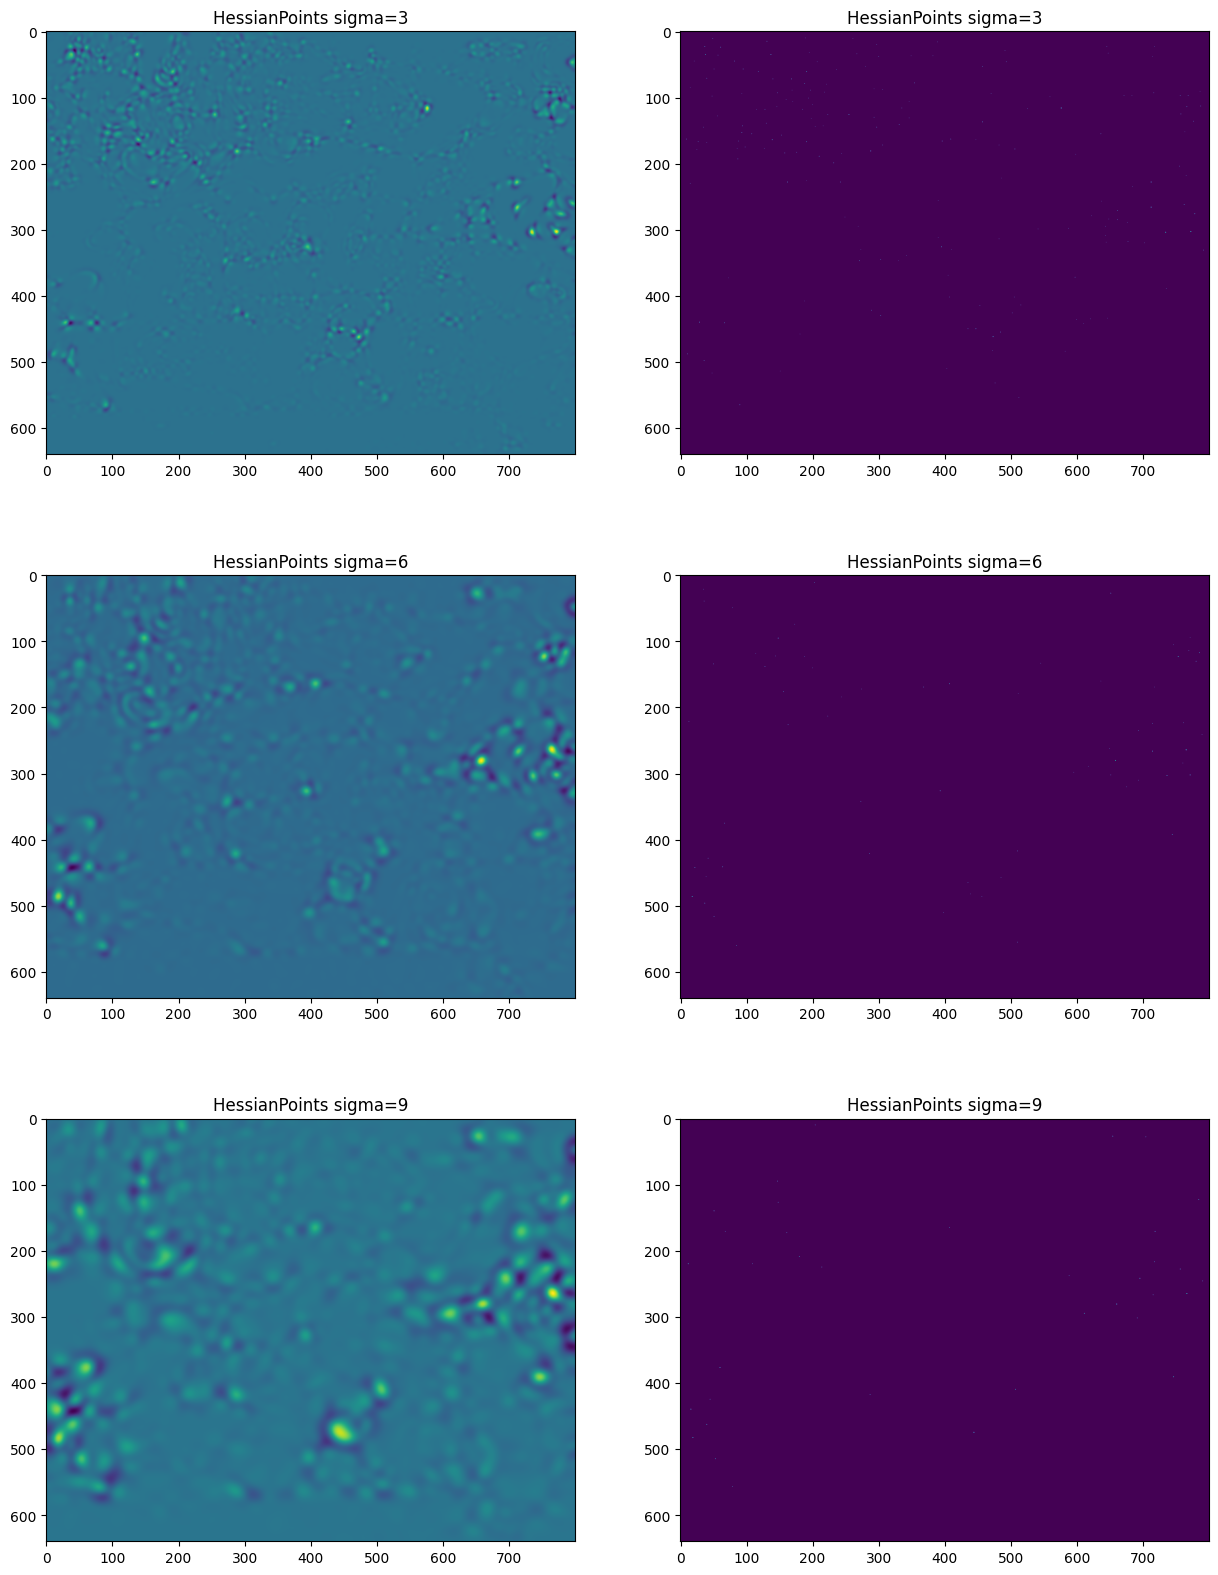

In [176]:
def non_maxima_suppression(det, hw):
    arr = np.copy(det)
    for y, row in enumerate(arr):
        for x, pixel in enumerate(row):
            if x < hw or y < hw or x >= len(row) - hw or y >= len(arr) - hw:
                arr[y, x] = 0
                continue
            if(det[y,x] < np.max(det[(y-hw):(y+hw+1),(x-hw):(x+hw+1)])):
                arr[y,x] = 0
    return arr

def hessian_points(Ixx, Iyy, Ixy, threshold):
    det = Ixx * Iyy - Ixy * Ixy
    nnmsDet = non_maxima_suppression(det, 8)
    nnmsDet[nnmsDet <= threshold] = 0.0
    return det, nnmsDet

det3, nnmsDet3 = hessian_points(Ixx3, Iyy3, Ixy3, 0.004)
det6, nnmsDet6 = hessian_points(Ixx6, Iyy6, Ixy6, 0.004)
det9, nnmsDet9 = hessian_points(Ixx9, Iyy9, Ixy9, 0.004)

f = plt.figure(figsize=(15, 20))
f.add_subplot(3, 2, 1)
plt.imshow(det3)
plt.title("HessianPoints sigma=3")
f.add_subplot(3, 2, 2)
plt.imshow(nnmsDet3)
plt.title("HessianPoints sigma=3")
f.add_subplot(3, 2, 3)
plt.imshow(det6)
plt.title("HessianPoints sigma=6")
f.add_subplot(3, 2, 4)
plt.imshow(nnmsDet6)
plt.title("HessianPoints sigma=6")
f.add_subplot(3, 2, 5)
plt.imshow(det9)
plt.title("HessianPoints sigma=9")
f.add_subplot(3, 2, 6)
plt.imshow(nnmsDet9)
plt.title("HessianPoints sigma=9")
plt.show()


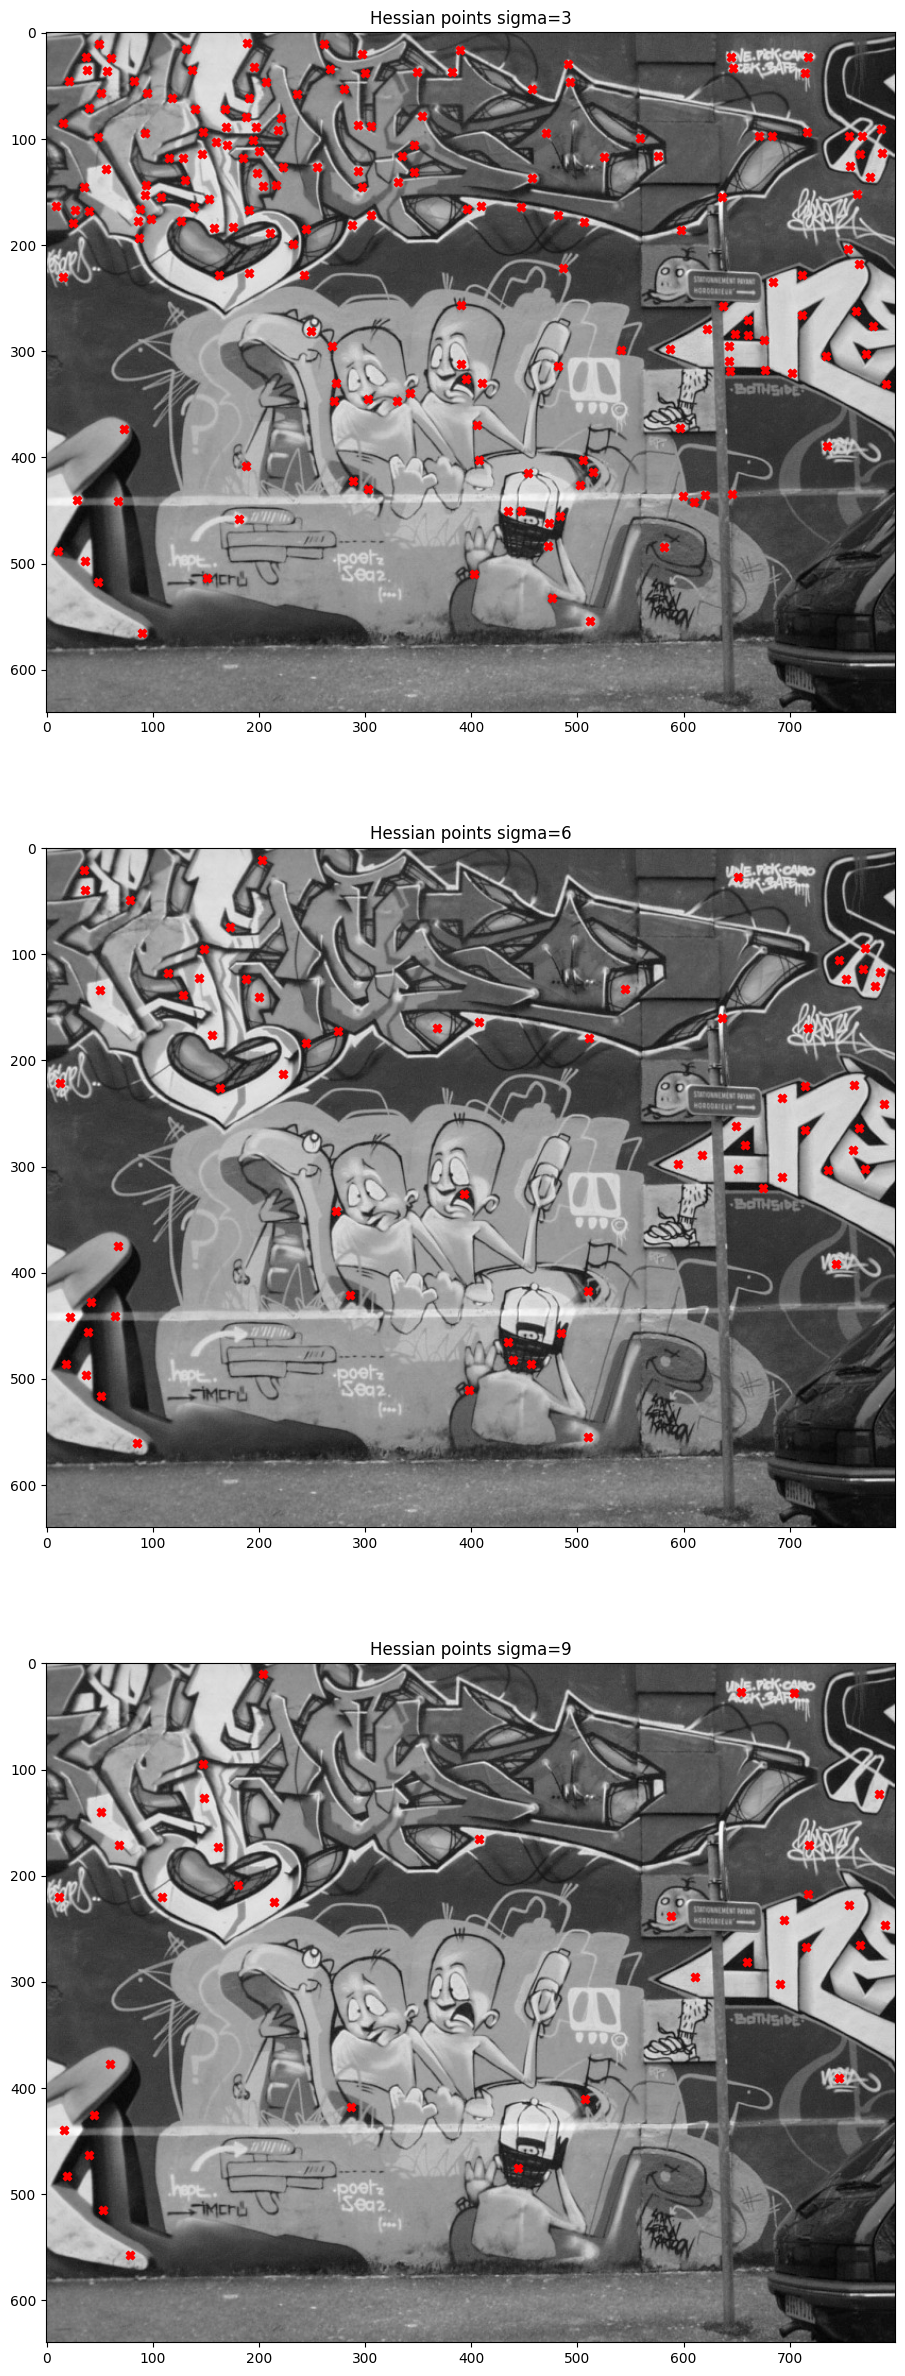

In [178]:
points = np.nonzero(nnmsDet3)
points2 = np.nonzero(nnmsDet6)
points3 = np.nonzero(nnmsDet9)
f = plt.figure(figsize=(30, 30))
f.add_subplot(3, 1, 1)
plt.imshow(temp, cmap="gray")
plt.scatter(points[1], points[0], c='red', marker='X')
plt.title("Hessian points sigma=3")

f.add_subplot(3, 1, 2)
plt.imshow(temp, cmap="gray")
plt.scatter(points2[1], points2[0], c='red', marker='X')
plt.title("Hessian points sigma=6")

f.add_subplot(3, 1, 3)
plt.imshow(temp, cmap="gray")
plt.scatter(points3[1], points3[0], c='red', marker='X')
plt.title("Hessian points sigma=9")
plt.show()

Question: What kind of structures in the image are detected by the algorithm?
How does the parameter σ affect the result?
Corners. Bigger σ means bigger corrner like objects will be detected and smaller will be smoothed out.

### b

In [198]:
def gaussFilter(img, sigma):
    gaussKenrnel = gauss(sigma)
    img = np.copy(temp.T)
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    return img

def auto_correlation_matrix(Ix, Iy, sigma):
    C11 = gaussFilter(Ix*Ix, sigma)
    C12 = gaussFilter(Ix*Iy, sigma)
    C21 = C12
    C22 = gaussFilter(Iy*Iy, sigma)
    return C11, C12, C21, C22
    

C11, C12, C21, C22 = auto_correlation_matrix(Ix3, Iy3, 1.6 * 3)


(array([], dtype=int64), array([], dtype=int64))


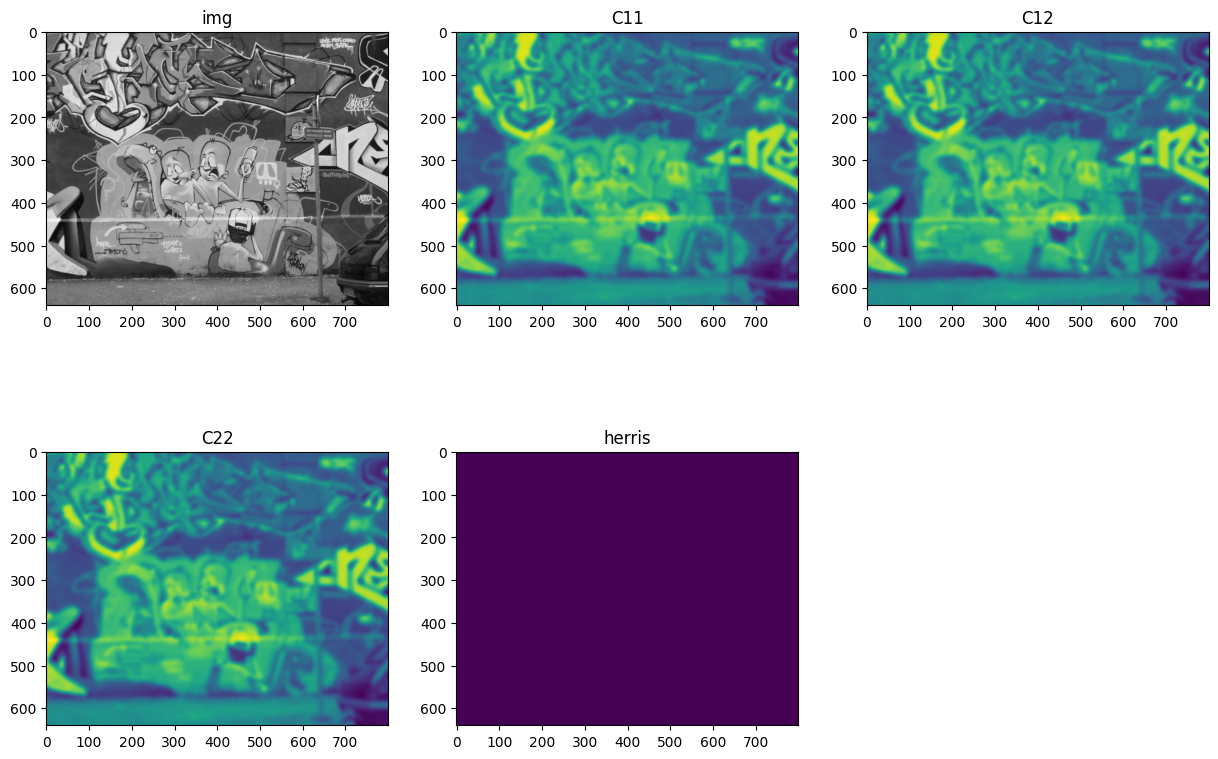

In [212]:
def herris_points(C11, C12, C21, C22, alpha, threshold):
    detC = C11*C22-C12*C21
    traceC = C11+C22

    arr = detC-alpha*traceC*traceC
    arr[arr <= threshold] = 0
    return arr

herris = herris_points(C11, C12, C21, C22, 0.06, 10**(-6))
print(herris.nonzero())

f = plt.figure(figsize=(15, 10))
f.add_subplot(2, 3, 1)
plt.imshow(temp, cmap="gray")
plt.title("img")
f.add_subplot(2, 3, 2)
plt.imshow(C11)
plt.title("C11")
f.add_subplot(2, 3, 3)
plt.imshow(C12)
plt.title("C12")
f.add_subplot(2, 3, 4)
plt.imshow(C22)
plt.title("C22")
f.add_subplot(2, 3, 5)
plt.imshow(herris)
plt.title("herris")
plt.show()